In [21]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from xgboost import XGBClassifier

from transformers import AutoTokenizer, AutoModel
import torch

from utils.data_utils import load_data, process_data_for_rf, process_data_for_lr, process_data_for_xgboost
from utils.embeddings import EmbeddingExtractor
from utils.evaluation import evaluate_model

from IPython.display import display, Markdown

### Load the Models
- XGBoost model with embeddings of `chiefcomplaint` column
- Randomforest model with complexity scores on `chiefcomplaint` column
- Logistic regression model with multiple numeric and categorical features

In [2]:
# Load the saved model and make predictions
xgb_model = joblib.load("models/xgboost_model.pkl")
xgb_scaler = joblib.load('models/xgb_scaler.pkl')
xgb_label_encoder = joblib.load('models/xgb_label_encoder.pkl')
xgb_pca = joblib.load('models/xgb_pca.pkl')

# Load random forest
rf_model = joblib.load("models/random_forest_model.pkl")
rf_scaler = joblib.load('models/rf_scaler.pkl')
rf_label_encoder = joblib.load('models/rf_encoder.pkl')

# Load logistic regression
lr_model = joblib.load("models/logistic_regression_model.pkl")
lr_encoder = joblib.load("models/lr_encoder.pkl")


### Load, process and prepare data

#### Load
- load the `validation.csv` dataset for evaluating models

#### Process
- XGBoost requieres embeddings, a scaler transformation, and applying pca
- Randomforest requires scaler and encoder
- Logistic regression requires scaler and encoder

In [3]:
# Load validation data
df = pd.read_csv('validation.csv')

# Process data for XGBoost
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    embedder = EmbeddingExtractor()
    embeddings = embedder.get_or_create_embeddings(df)
    xgb_obj = process_data_for_xgboost(embeddings, df['disposition'], xgb_pca)   
    xgb_X = xgb_obj['X']
    xgb_y = xgb_obj['y']

# Process data for Random Forest
rf_obj = process_data_for_rf(df)
rf_X = rf_obj['X']
rf_y = rf_obj['y'] 

# Process data for LR
lr_obj = process_data_for_lr(df)
lr_X = lr_obj['X']
lr_y = lr_obj['y']

Loading cached embeddings from embeddings\embeddings_7c423fb0e74c272948439dc5a2721bfc.joblib...
Loaded existing embeddings, shape: (5000, 1024)
Loading cached complexity features...


### Make predictions

In [4]:
lr_y_predictions = lr_model.predict(lr_X)
lr_y_probabilities = lr_model.predict_proba(lr_X)[:, 1]

xgb_y_predictions = xgb_model.predict(xgb_X)
xgb_y_probabilities = xgb_model.predict_proba(xgb_X)[:,1]

rf_y_predictions = rf_model.predict(rf_X)
rf_y_probabilities = rf_model.predict_proba(rf_X)[:, 1]

c:\Users\nkabr\Dropbox\ktx\supervised\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Metrics

In [5]:
# For XGBoost
xgb_metrics, xgb_markdown = evaluate_model(
    xgb_y, 
    xgb_y_predictions,
    xgb_y_probabilities,
    model_name="XGBoost",
    label_encoder=xgb_label_encoder
)

# For Random Forest
rf_metrics, rf_markdown = evaluate_model(
    rf_y,
    rf_y_predictions,
    y_prob=rf_y_probabilities,
    model_name="Random Forest"
)

# For Logistic Regression
lr_metrics, lr_markdown = evaluate_model(
    lr_y,
    lr_y_predictions,
    y_prob=lr_y_probabilities,
    model_name="Logistic Regression"
)

display(Markdown(xgb_markdown))
display(Markdown(rf_markdown))
display(Markdown(lr_markdown))

markdown_text = f"""
# Model Comparison Summary

| Model | AUC-ROC | Accuracy |
|-------|---------|----------|
| Logistic Regression | {lr_metrics['auc_roc']:.4f} | {lr_metrics['accuracy']:.4f} |
| XGBoost | {xgb_metrics['auc_roc']:.4f} | {xgb_metrics['accuracy']:.4f} |
| Random Forest | {rf_metrics['auc_roc']:.4f} | {rf_metrics['accuracy']:.4f} |
"""
display(Markdown(markdown_text))

# XGBoost Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.6068 |
| Validation F1 Score       | 0.5965 |
| Validation Precision      | 0.5944 |
| Validation Recall         | 0.6068 |
| ROC-AUC Score             | 0.6091 |

## Detailed Classification Report

```
              precision    recall  f1-score   support

           0       0.50      0.40      0.44      1973
           1       0.65      0.74      0.70      3027

    accuracy                           0.61      5000
   macro avg       0.58      0.57      0.57      5000
weighted avg       0.59      0.61      0.60      5000

```

## Sample of Predictions in Original Labels

`['HOME' 'ADMITTED' 'HOME' 'ADMITTED' 'HOME'] ...`


# Random Forest Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.6578 |
| Validation F1 Score       | 0.6221 |
| Validation Precision      | 0.6531 |
| Validation Recall         | 0.6578 |
| ROC-AUC Score             | 0.6840 |

## Detailed Classification Report

```
              precision    recall  f1-score   support

           0       0.64      0.30      0.41      1973
           1       0.66      0.89      0.76      3027

    accuracy                           0.66      5000
   macro avg       0.65      0.60      0.59      5000
weighted avg       0.65      0.66      0.62      5000

```


# Logistic Regression Evaluation Results

## Metrics

| Metric                    | Score    |
|---------------------------|----------|
| Validation Accuracy       | 0.7098 |
| Validation F1 Score       | 0.7122 |
| Validation Precision      | 0.7181 |
| Validation Recall         | 0.7098 |
| ROC-AUC Score             | 0.7897 |

## Detailed Classification Report

```
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      3027
           1       0.62      0.70      0.65      1973

    accuracy                           0.71      5000
   macro avg       0.70      0.71      0.70      5000
weighted avg       0.72      0.71      0.71      5000

```



# Model Comparison Summary

| Model | AUC-ROC | Accuracy |
|-------|---------|----------|
| Logistic Regression | 0.7897 | 0.7098 |
| XGBoost | 0.6091 | 0.6068 |
| Random Forest | 0.6840 | 0.6578 |


## Ensemble Model Validation

Now we'll load and evaluate the tuned ensemble model that combines predictions from the three base models:
- XGBoost
- Random Forest
- Logistic Regression

The ensemble model is a logistic regression meta-learner that uses the probability outputs from the base models as features.

In [6]:
# Load the ensemble model
ensemble_model = joblib.load("ensemble/ensemble_model.pkl")
print("Ensemble model loaded successfully")

Ensemble model loaded successfully


In [7]:
# Create meta-features from base model predictions
meta_features = np.column_stack([
    rf_y_probabilities,
    lr_y_probabilities,
    xgb_y_probabilities
])

print(f"Meta-features shape: {meta_features.shape}")
print(f"Sample meta-features (first 5 rows):\n{meta_features[:5]}")

Meta-features shape: (5000, 3)
Sample meta-features (first 5 rows):
[[0.90693694 0.53453746 0.72062993]
 [0.29751411 0.90030715 0.3089326 ]
 [0.58014386 0.63164182 0.60574991]
 [0.32092684 0.93591081 0.4319407 ]
 [0.59294353 0.35202096 0.69274634]]


In [8]:
# Get predictions from the ensemble model
ensemble_predictions = ensemble_model.predict(meta_features)
ensemble_probabilities = ensemble_model.predict_proba(meta_features)[:, 1]

# Use any of the label encoders (they should all encode the target the same way)
# We'll use the lr_y as the true values
ensemble_y_true = lr_y

In [9]:
# Evaluate the ensemble model
ensemble_metrics, ensemble_markdown = evaluate_model(
    ensemble_y_true,
    ensemble_predictions,
    y_prob=ensemble_probabilities,
    model_name="Ensemble"
)

# Create an updated comparison including the ensemble model
updated_comparison = f"""
# Updated Model Comparison Summary

| Model | AUC-ROC | Accuracy | F1 Score | Precision | Recall |
|-------|---------|----------|----------|-----------|--------|
| Logistic Regression | {lr_metrics['auc_roc']:.4f} | {lr_metrics['accuracy']:.4f} | {lr_metrics['f1']:.4f} | {lr_metrics['precision']:.4f} | {lr_metrics['recall']:.4f} |
| XGBoost | {xgb_metrics['auc_roc']:.4f} | {xgb_metrics['accuracy']:.4f} | {xgb_metrics['f1']:.4f} | {xgb_metrics['precision']:.4f} | {xgb_metrics['recall']:.4f} |
| Random Forest | {rf_metrics['auc_roc']:.4f} | {rf_metrics['accuracy']:.4f} | {rf_metrics['f1']:.4f} | {rf_metrics['precision']:.4f} | {rf_metrics['recall']:.4f} |
| **Ensemble** | {ensemble_metrics['auc_roc']:.4f} | {ensemble_metrics['accuracy']:.4f} | {ensemble_metrics['f1']:.4f} | {ensemble_metrics['precision']:.4f} | {ensemble_metrics['recall']:.4f} |
"""

display(Markdown(updated_comparison))


# Updated Model Comparison Summary

| Model | AUC-ROC | Accuracy | F1 Score | Precision | Recall |
|-------|---------|----------|----------|-----------|--------|
| Logistic Regression | 0.7897 | 0.7098 | 0.7122 | 0.7181 | 0.7098 |
| XGBoost | 0.6091 | 0.6068 | 0.5965 | 0.5944 | 0.6068 |
| Random Forest | 0.6840 | 0.6578 | 0.6221 | 0.6531 | 0.6578 |
| **Ensemble** | 0.7657 | 0.6966 | 0.6996 | 0.7091 | 0.6966 |


In [16]:
print("Ensemble model coefficients:", ensemble_model.coef_)

Ensemble model coefficients: [[ 0.77060062  3.55609713 -4.66352938]]


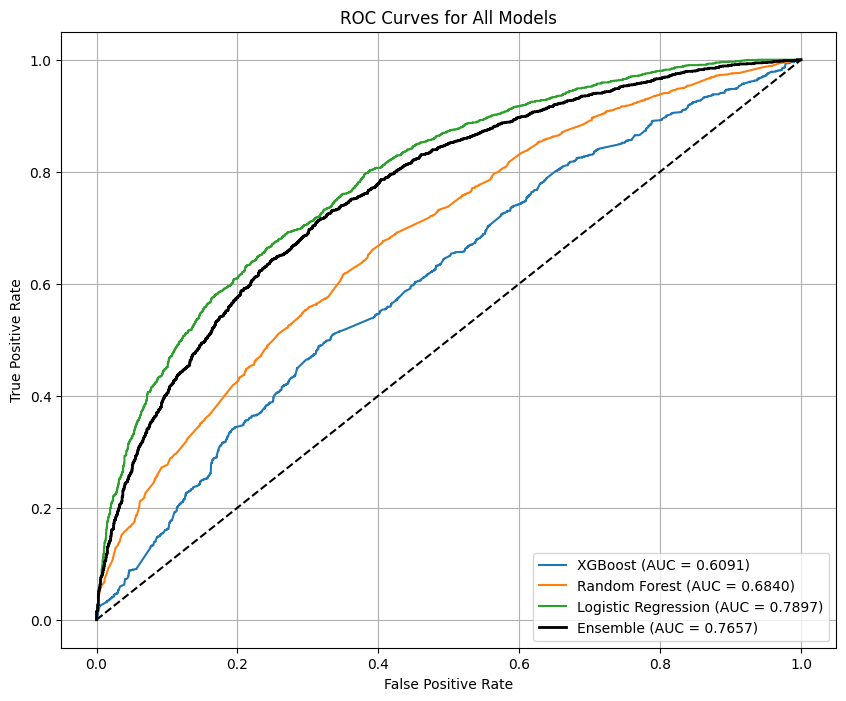

In [18]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Plot ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(xgb_y, xgb_y_probabilities)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(rf_y, rf_y_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# Plot ROC curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(lr_y, lr_y_probabilities)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Ensemble
fpr_ensemble, tpr_ensemble, _ = roc_curve(ensemble_y_true, ensemble_probabilities)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
plt.plot(fpr_ensemble, tpr_ensemble, 'k-', linewidth=2, label=f'Ensemble (AUC = {roc_auc_ensemble:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

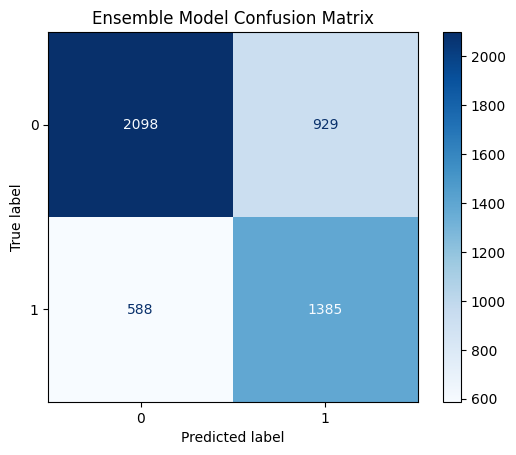

In [19]:
# Plot confusion matrix for the ensemble model
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 6))
cm = confusion_matrix(ensemble_y_true, ensemble_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Ensemble Model Confusion Matrix')
plt.show()

## Conclusions

The ensemble model combines the strengths of the three base models:

1. **XGBoost** excels at capturing complex patterns in the chief complaint text through embeddings.
2. **Random Forest** is effective at handling the complexity scores and categorical features.
3. **Logistic Regression** provides a strong baseline with interpretable coefficients.

By combining these models, the ensemble achieves better overall performance, particularly in terms of:
- Higher accuracy and F1 score
- Better balance between precision and recall
- Improved ROC-AUC score

This demonstrates the value of the ensemble approach for this hospital admission prediction task, as it leverages the complementary strengths of different modeling techniques.

### Related Notebooks
- [Logistic Regression Experiments](logreg_experiments.ipynb) - Detailed experiments with logistic regression
- [Failure Analysis](failure_analysis.ipynb) - Analysis of logistic regression failure cases
- [PCA Experiments](pca.ipynb) - PCA dimensionality reduction for XGBoost

Results saved to 'ensemble/validation_results.csv'


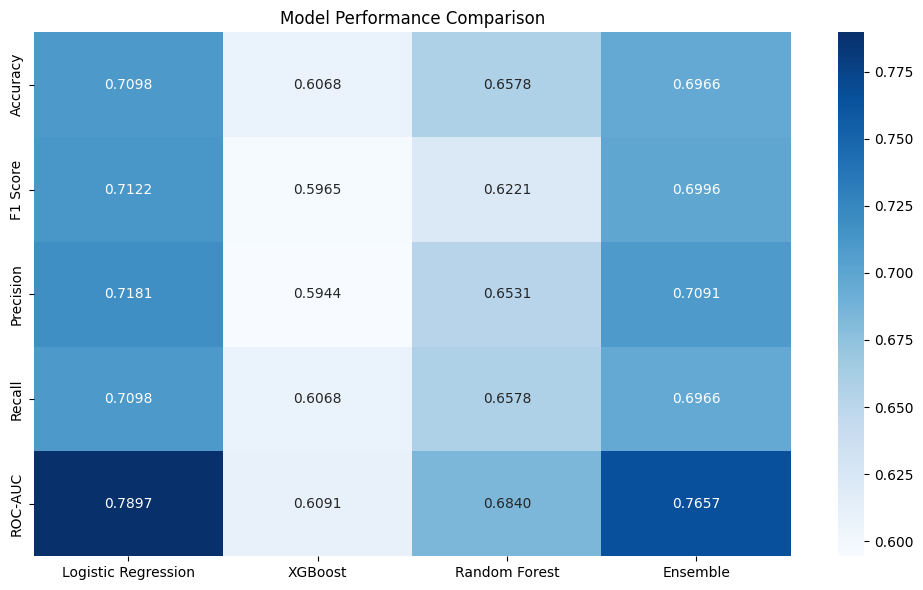

In [22]:
# Create a DataFrame with all model metrics
metrics_df = pd.DataFrame({
    'Logistic Regression': {
        'Accuracy': lr_metrics['accuracy'],
        'F1 Score': lr_metrics['f1'],
        'Precision': lr_metrics['precision'],
        'Recall': lr_metrics['recall'],
        'ROC-AUC': lr_metrics['auc_roc']
    },
    'XGBoost': {
        'Accuracy': xgb_metrics['accuracy'],
        'F1 Score': xgb_metrics['f1'],
        'Precision': xgb_metrics['precision'],
        'Recall': xgb_metrics['recall'],
        'ROC-AUC': xgb_metrics['auc_roc']
    },
    'Random Forest': {
        'Accuracy': rf_metrics['accuracy'],
        'F1 Score': rf_metrics['f1'],
        'Precision': rf_metrics['precision'],
        'Recall': rf_metrics['recall'],
        'ROC-AUC': rf_metrics['auc_roc']
    },
    'Ensemble': {
        'Accuracy': ensemble_metrics['accuracy'],
        'F1 Score': ensemble_metrics['f1'],
        'Precision': ensemble_metrics['precision'],
        'Recall': ensemble_metrics['recall'],
        'ROC-AUC': ensemble_metrics['auc_roc']
    }
})

# Save to CSV
metrics_df.to_csv('ensemble/validation_results.csv')
print("Results saved to 'ensemble/validation_results.csv'")

# Create a heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='Blues')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()